# <center>Real NVP [1]</center>

In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D

import torchvision

import matplotlib.pyplot as plt
import numpy as np

from copy import deepcopy

from utils.NF_base import *
from utils.training_moons import *
from utils.training_mnist import *

from sw import *

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
# https://github.com/VincentStimper/normalizing-flows/blob/master/normflow/flows.py

class AffineCoupling(BaseNormalizingFlow):
    """
        Affine Coupling layer as introduced RealNVP paper, see arXiv: 1605.08803
    """

    def __init__(self, param_map, scale=True, scale_map='exp'):
        """
        Constructor
        :param param_map: Maps features to shift and scale parameter (if applicable)
        :param scale: Flag whether scale shall be applied
        :param scale_map: Map to be applied to the scale parameter, can be 'exp' as in
        RealNVP or 'sigmoid' as in Glow
        """
        super().__init__()
        self.add_module('param_map', param_map)
        self.scale = scale
        self.scale_map = scale_map

    def forward(self, z):
        """
        z is a list of z1 and z2; z = [z1, z2]
        z1 is left constant and affine map is applied to z2 with parameters depending
        on z1
        """
        z1, z2 = z
        param = self.param_map(z1)
        if self.scale:
            shift = param[:, 0::2, ...]
            scale_ = param[:, 1::2, ...]
            if self.scale_map == 'exp':
                z2 = z2 * torch.exp(scale_) + shift
                log_det = torch.sum(scale_, dim=list(range(1, shift.dim())))
            elif self.scale_map == 'sigmoid':
                scale = torch.sigmoid(scale_ + 2)
                z2 = z2 / scale + shift
                log_det = -torch.sum(torch.log(scale), dim=list(range(1, shift.dim())))
            else:
                raise NotImplementedError('This scale map is not implemented.')
        else:
            z2 += param
            log_det = 0
                    
        return [z1,z2], log_det

    def backward(self, z):
        z1, z2 = z
        param = self.param_map(z1)
        if self.scale:
            shift = param[:, 0::2, ...]
            scale_ = param[:, 1::2, ...]
            if self.scale_map == 'exp':
                z2 = (z2 - shift) * torch.exp(-scale_)
                log_det = -torch.sum(scale_, dim=list(range(1, shift.dim())))
            elif self.scale_map == 'sigmoid':
                scale = torch.sigmoid(scale_ + 2)
                z2 = (z2 - shift) * scale
                log_det = torch.sum(torch.log(scale), dim=list(range(1, shift.dim())))
            else:
                raise NotImplementedError('This scale map is not implemented.')
        else:
            z2 -= param
            log_det = 0
                        
        return [z1,z2], log_det
    
    
class Split(BaseNormalizingFlow):
    """
    Split features into two sets
    """
    def __init__(self, mode='channel'):
        """
        Constructor
        :param mode: Splitting mode, can be
            channel: Splits first feature dimension, usually channels, into two halfs
            channel_inv: Same as channel, but with z1 and z2 flipped
            checkerboard: Splits features using a checkerboard pattern (last feature dimension must be even)
            checkerboard_inv: Same as checkerboard, but with inverted coloring
        """
        super().__init__()
        self.mode = mode

    def forward(self, z):
        if self.mode == 'channel':
            z1, z2 = z.chunk(2, dim=1)
        elif self.mode == 'channel_inv':
            z2, z1 = z.chunk(2, dim=1)
        elif 'checkerboard' in self.mode:
            n_dims = z.dim()
            cb0 = 0
            cb1 = 1
            for i in range(1, n_dims):
                cb0_ = cb0
                cb1_ = cb1
                cb0 = [cb0_ if j % 2 == 0 else cb1_ for j in range(z.size(n_dims - i))]
                cb1 = [cb1_ if j % 2 == 0 else cb0_ for j in range(z.size(n_dims - i))]
            cb = cb1 if 'inv' in self.mode else cb0
            cb = torch.tensor(cb)[None].repeat(len(z), *((n_dims - 1) * [1]))
            cb = cb.to(z.device)
            z_size = z.size()
            z1 = z.reshape(-1)[torch.nonzero(cb.view(-1), as_tuple=False)].view(*z_size[:-1], -1)
            z2 = z.reshape(-1)[torch.nonzero((1 - cb).view(-1), as_tuple=False)].view(*z_size[:-1], -1)
        else:
            raise NotImplementedError('Mode ' + self.mode + ' is not implemented.')
        log_det = 0
                
        return [z1,z2], log_det

    def backward(self, z):
        z1, z2 = z
        if self.mode == 'channel':
            z = torch.cat([z1, z2], 1)
        elif self.mode == 'channel_inv':
            z = torch.cat([z2, z1], 1)
        elif 'checkerboard' in self.mode:
            n_dims = z1.dim()
            z_size = list(z1.size())
            z_size[-1] *= 2
            cb0 = 0
            cb1 = 1
            for i in range(1, n_dims):
                cb0_ = cb0
                cb1_ = cb1
                cb0 = [cb0_ if j % 2 == 0 else cb1_ for j in range(z_size[n_dims - i])]
                cb1 = [cb1_ if j % 2 == 0 else cb0_ for j in range(z_size[n_dims - i])]
            cb = cb1 if 'inv' in self.mode else cb0
            cb = torch.tensor(cb)[None].repeat(z_size[0], *((n_dims - 1) * [1]))
            cb = cb.to(z1.device)
            z1 = z1[..., None].repeat(*(n_dims * [1]), 2).view(*z_size[:-1], -1)
            z2 = z2[..., None].repeat(*(n_dims * [1]), 2).view(*z_size[:-1], -1)
            z = cb * z1 + (1 - cb) * z2
        else:
            raise NotImplementedError('Mode ' + self.mode + ' is not implemented.')
        log_det = 0
        return z, log_det


class Merge(Split):
    """
    Same as Split but with forward and backward pass interchanged
    """
    def __init__(self, mode='channel'):
        super().__init__(mode)

    def forward(self, z):
        return super().backward(z)

    def backward(self, z):
        return super().forward(z)
    
    
    
class AffineCouplingBlock(BaseNormalizingFlow):
    """
    Affine Coupling layer including split and merge operation
    """
    def __init__(self, param_map, scale=True, scale_map='exp', split_mode='channel'):
        """
        Constructor
        :param param_map: Maps features to shift and scale parameter (if applicable)
        :param scale: Flag whether scale shall be applied
        :param scale_map: Map to be applied to the scale parameter, can be 'exp' as in
        RealNVP or 'sigmoid' as in Glow
        :param split_mode: Splitting mode, for possible values see Split class
        """
        super().__init__()
        self.flows = nn.ModuleList([])
        # Split layer
        self.flows += [Split(split_mode)]
        # Affine coupling layer
        self.flows += [AffineCoupling(param_map, scale, scale_map)]
        # Merge layer
        self.flows += [Merge(split_mode)]

    def forward(self, z):
        log_det_tot = torch.zeros(z.shape[0], dtype=z.dtype, device=z.device)
        for flow in self.flows:
            z, log_det = flow(z)
            log_det_tot += log_det            
        return z, log_det_tot

    def backward(self, z):
        log_det_tot = torch.zeros(z.shape[0], dtype=z.dtype, device=z.device)
        for i in range(len(self.flows) - 1, -1, -1):
            z, log_det = self.flows[i].backward(z)
            log_det_tot += log_det
        return z, log_det_tot
    
    
class Permute(BaseNormalizingFlow):
    """
    Permutation features along the channel dimension
    """
    def __init__(self, num_channels, mode='shuffle'):
        """
        Constructor
        :param num_channel: Number of channels
        :param mode: Mode of permuting features, can be shuffle for
        random permutation or swap for interchanging upper and lower part
        """
        super().__init__()
        self.mode = mode
        self.num_channels = num_channels
        if self.mode == 'shuffle':
            perm = torch.randperm(self.num_channels)
            inv_perm = torch.empty_like(perm).scatter_(dim=0, index=perm,
                                                       src=torch.arange(self.num_channels))
            self.register_buffer("perm", perm)
            self.register_buffer("inv_perm", inv_perm)

    def forward(self, z):
        if self.mode == 'shuffle':
            z = z[:, self.perm, ...]
        elif self.mode == 'swap':
            z1 = z[:, :self.num_channels // 2, ...]
            z2 = z[:, self.num_channels // 2:, ...]
            z = torch.cat([z2, z1], dim=1)
        else:
            raise NotImplementedError('The mode ' + self.mode + ' is not implemented.')
        log_det = 0
        return z, log_det

    def backward(self, z):
        if self.mode == 'shuffle':
            z = z[:, self.inv_perm, ...]
        elif self.mode == 'swap':
            z1 = z[:, :(self.num_channels + 1) // 2, ...]
            z2 = z[:, (self.num_channels + 1) // 2:, ...]
            z = torch.cat([z2, z1], dim=1)
        else:
            raise NotImplementedError('The mode ' + self.mode + ' is not implemented.')
        log_det = 0
        return z, log_det
    
    
class AffineConstFlow(BaseNormalizingFlow):
    """
    scales and shifts with learned constants per dimension. In the NICE paper there is a
    scaling layer which is a special case of this where t is None
    """

    def __init__(self, shape, scale=True, shift=True):
        """
        Constructor
        :param shape: Shape of the coupling layer
        :param scale: Flag whether to apply scaling
        :param shift: Flag whether to apply shift
        :param logscale_factor: Optional factor which can be used to control
        the scale of the log scale factor
        """
        super().__init__()
        if scale:
            self.s = nn.Parameter(torch.zeros(shape)[None])
        else:
            self.register_buffer('s', torch.zeros(shape)[None])
        if shift:
            self.t = nn.Parameter(torch.zeros(shape)[None])
        else:
            self.register_buffer('t', torch.zeros(shape)[None])
        self.n_dim = self.s.dim()
        self.batch_dims = torch.nonzero(torch.tensor(self.s.shape) == 1, as_tuple=False)[:, 0].tolist()

    def forward(self, z):
        z_ = z * torch.exp(self.s) + self.t
        if len(self.batch_dims) > 1:
            prod_batch_dims = np.prod([z.size(i) for i in self.batch_dims[1:]])
        else:
            prod_batch_dims = 1
        log_det = prod_batch_dims * torch.sum(self.s)
        return z_, log_det

    def backward(self, z):
        z_ = (z - self.t) * torch.exp(-self.s)
        if len(self.batch_dims) > 1:
            prod_batch_dims = np.prod([z.size(i) for i in self.batch_dims[1:]])
        else:
            prod_batch_dims = 1
        log_det = -prod_batch_dims * torch.sum(self.s)
        return z_, log_det
    
    
class ActNorm(AffineConstFlow):
    """
    An AffineConstFlow but with a data-dependent initialization,
    where on the very first batch we clever initialize the s,t so that the output
    is unit gaussian. As described in Glow paper.
    """

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.data_dep_init_done_cpu = torch.tensor(0.)
        self.register_buffer('data_dep_init_done', self.data_dep_init_done_cpu)

    def forward(self, z):
        # first batch is used for initialization, c.f. batchnorm
        if not self.data_dep_init_done > 0.:
            assert self.s is not None and self.t is not None
            s_init = -torch.log(z.std(dim=self.batch_dims, keepdim=True) + 1e-6)
            self.s.data = s_init.data
            self.t.data = (-z.mean(dim=self.batch_dims, keepdim=True) * torch.exp(self.s)).data
            self.data_dep_init_done = torch.tensor(1.)
        return super().forward(z)

    def backward(self, z):
        # first batch is used for initialization, c.f. batchnorm
        if not self.data_dep_init_done:
            assert self.s is not None and self.t is not None
            s_init = torch.log(z.std(dim=self.batch_dims, keepdim=True) + 1e-6)
            self.s.data = s_init.data
            self.t.data = z.mean(dim=self.batch_dims, keepdim=True).data
            self.data_dep_init_done = torch.tensor(1.)
        return super().backward(z)

In [17]:
class NormalizingFlows(BaseNormalizingFlow):
    """
        Composition of flows
        
        Refs: 
        - https://github.com/karpathy/pytorch-normalizing-flows/blob/master/nflib/flows.py
    """
    def __init__(self, flows, q0):
        """
    		Inputs:
    		- flows: list of BaseNormalizingFlows objects
    	"""
        super().__init__()
        self.flows = nn.ModuleList(flows)
        self.q0 = q0
        
    def forward(self, x):
        log_det = torch.zeros(x.shape[0], device=device)
        zs = [x]
        for flow in self.flows:
            x, log_det_i = flow(x)
            log_det += log_det_i
            zs.append(x)
        return zs, log_det
    
    def backward(self, z):
        log_det = torch.zeros(z.shape[0], device=device)
        xs = [z]
        for flow in self.flows[::-1]:
            z, log_det_i = flow.backward(z)
            log_det += log_det_i
            xs.append(z)
        return xs, log_det
    
    def forward_kl(self, x):
        zs, log_det = self.backward(x) ## x=T(z)
        prior = self.q0.log_prob(zs[-1]).mean()
        return -(prior+log_det.mean())

In [18]:
## https://github.com/VincentStimper/normalizing-flows/blob/master/normflow/nets.py

class MLP(nn.Module):
    """
    A multilayer perceptron with Leaky ReLU nonlinearities
    """

    def __init__(self, layers, leaky=0.0, score_scale=None, output_fn=None,
                 output_scale=None, init_zeros=False, dropout=None):
        """
        :param layers: list of layer sizes from start to end
        :param leaky: slope of the leaky part of the ReLU,
        if 0.0, standard ReLU is used
        :param score_scale: Factor to apply to the scores, i.e. output before
        output_fn.
        :param output_fn: String, function to be applied to the output, either
        None, "sigmoid", "relu", "tanh", or "clampexp"
        :param output_scale: Rescale outputs if output_fn is specified, i.e.
        scale * output_fn(out / scale)
        :param init_zeros: Flag, if true, weights and biases of last layer
        are initialized with zeros (helpful for deep models, see arXiv 1807.03039)
        :param dropout: Float, if specified, dropout is done before last layer;
        if None, no dropout is done
        """
        super().__init__()
        net = nn.ModuleList([])
        for k in range(len(layers)-2):
            net.append(nn.Linear(layers[k], layers[k+1]))
            net.append(nn.LeakyReLU(leaky))
        if dropout is not None:
            net.append(nn.Dropout(p=dropout))
        net.append(nn.Linear(layers[-2], layers[-1]))
        if init_zeros:
            nn.init.zeros_(net[-1].weight)
            nn.init.zeros_(net[-1].bias)
        if output_fn is not None:
            if score_scale is not None:
                net.append(utils.ConstScaleLayer(score_scale))
            if output_fn == "sigmoid":
                net.append(nn.Sigmoid())
            elif output_fn == "relu":
                net.append(nn.ReLU())
            elif output_fn == "tanh":
                net.append(nn.Tanh())
            elif output_fn == "clampexp":
                net.append(utils.ClampExp())
            else:
                NotImplementedError("This output function is not implemented.")
            if output_scale is not None:
                net.append(utils.ConstScaleLayer(output_scale))
        self.net = nn.Sequential(*net)

    def forward(self, x):
        return self.net(x)

In [19]:
def val_moons(model, i, device, xmin=-1.5, xmax=2.5, ymin=-0.75, ymax=1.25):
    model.eval()

    xline = torch.linspace(xmin, xmax, 100)
    yline = torch.linspace(ymin, ymax, 100)
    xgrid, ygrid = torch.meshgrid(xline, yline)
    xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

    with torch.no_grad():
        xy, log_s = model.backward(xyinput.to(device))
        zz = (log_likelihood(xy[-1],log_s,model.q0)).exp().cpu()
        zgrid = zz.reshape(100,100)

        z = model.q0.sample((100,))
        xs, log_det = model(z)
        x = xs[-1].detach()
        x = x.cpu().numpy()
        z = z.cpu().numpy()

    plt.contourf(xgrid.numpy(), ygrid.numpy(), zgrid.numpy())
    plt.colorbar()
    plt.scatter(x[:,0],x[:,1],c="red")
    plt.scatter(z[:,0],z[:,1],c="green")
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.title('iteration {}'.format(i + 1))
    plt.show()
    
    
def loss(h,log_det,distr,base_distr="normal"):
    if base_distr == "logistic":
        prior = distr.log_prob(h).sum(1).mean(0)
    else:
        prior = distr.log_prob(h).mean()
    return -(prior+log_det.mean())

def log_likelihood(h,log_det,distr,base_distr="normal"):
    if base_distr == "logistic":
        prior = distr.log_prob(h).sum(1)
    else:
        prior = distr.log_prob(h)
    return prior+log_det    
    
def train_moons(model, optimizer, n_epochs=10001, d=2, 
				device=None, plot_val=True, plot_interval=1000, batch_size=1024,
                input_grad=False):
    
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    train_loss = []
    
    pbar = trange(n_epochs)

    for i in pbar: #range(n_epochs):        
        x, y = datasets.make_moons(batch_size, noise=.1)
        x = torch.tensor(x, dtype=torch.float32,requires_grad=input_grad).to(device)

        model.train()

#         z, log_det = model(x)
#         l = loss(z[-1],log_det,distr,base_distr)
        
        l = model.forward_kl(x)

        l.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss.append(l.item())
        
        if i%100==0:
            pbar.set_postfix_str(f"loss = {train_loss[-1]:.3f}")

        if plot_val and i % plot_interval == 0:
            print(i,train_loss[-1])
            val_moons(model, i, device)
            
    return train_loss

### 2 Moons

In [114]:
d = 2


q0 = D.MultivariateNormal(torch.zeros(d, device=device), torch.eye(d,device=device))

flows = []
for i in range(5):
#     param_map = MLP([d // 2, 32, 32, d], init_zeros=True)
    param_map = MLP([d // 2, 32, 32, d], init_zeros=True)
    flows.append(AffineCouplingBlock(param_map))
    flows += [Permute(d, mode='swap')]
    flows += [ActNorm(d)]

    

model = NormalizingFlows(flows, q0).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  5950


  0%|          | 0/10001 [00:00<?, ?it/s]

0 2.0119664669036865


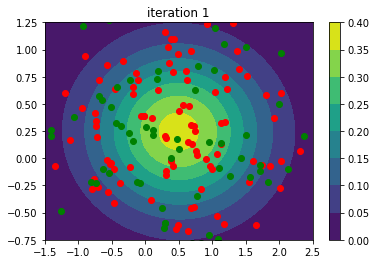

1000 1.226484775543213


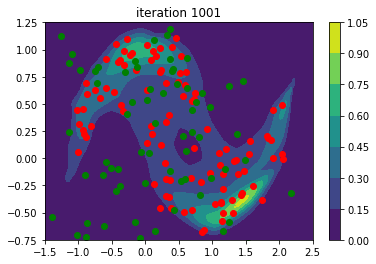

2000 1.1894538402557373


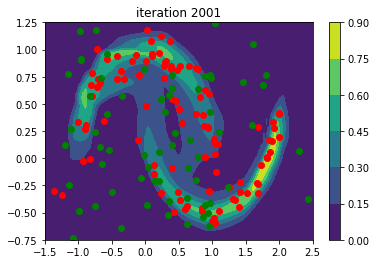

3000 1.09981369972229


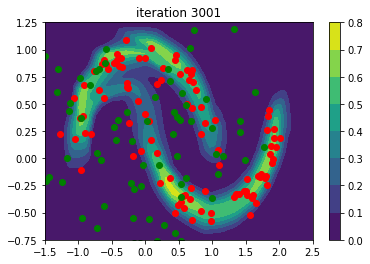

4000 1.0514788627624512


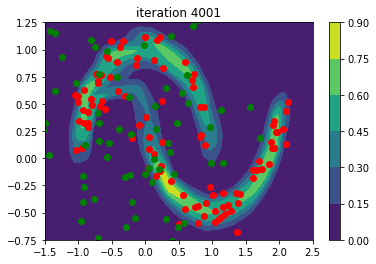

5000 1.0627498626708984


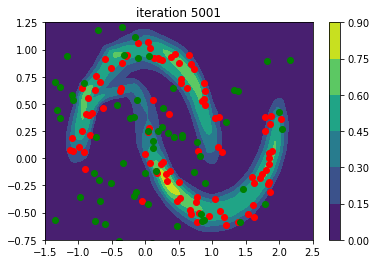

6000 1.0038535594940186


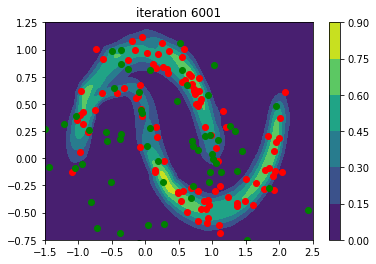

7000 1.058835744857788


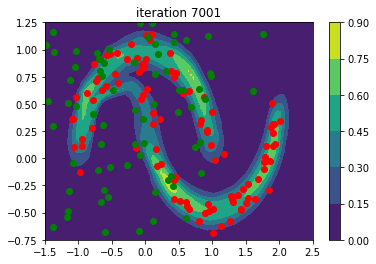

8000 1.0358026027679443


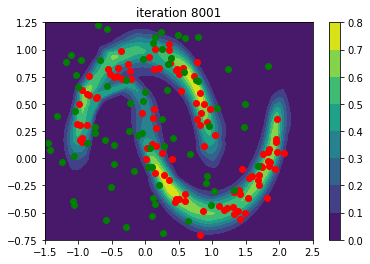

9000 1.0453747510910034


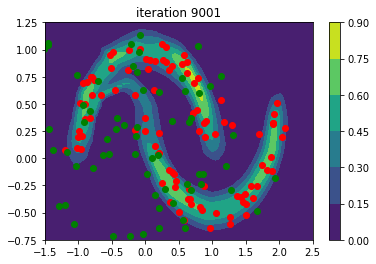

10000 1.056092619895935


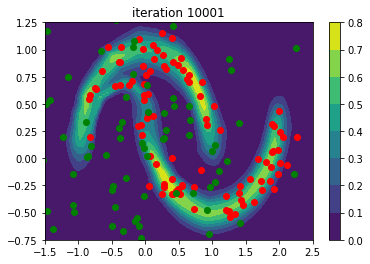

In [115]:
train_loss = train_moons(model,optimizer, batch_size=1024, n_epochs=10001)

### Gaussians

In [116]:
def create_gaussians(num_points):
    """
        Adapted from https://github.com/rtqichen/ffjord/blob/master/lib/toy_data.py
    """
    scale = 4.
    bias = np.pi / 8
    step = np.pi / 4
    centers = [(np.cos(bias + 0*step), np.sin(bias + 0*step)),
               (np.cos(bias + 1*step), np.sin(bias + 1*step)),
               (np.cos(bias + 2*step), np.sin(bias + 2*step)),
               (np.cos(bias + 3*step), np.sin(bias + 3*step)),
               (np.cos(bias + 4*step), np.sin(bias + 4*step)),
               (np.cos(bias + 5*step), np.sin(bias + 5*step)),
               (np.cos(bias + 6*step), np.sin(bias + 6*step)),
               (np.cos(bias + 7*step), np.sin(bias + 7*step))]
    centers = [(scale * x, scale * y) for x, y in centers]

    dataset = []
    for i in range(num_points):
        point = np.random.randn(2) * 0.5
        idx = np.random.randint(8)
        center = centers[idx]
        point[0] += center[0]
        point[1] += center[1]
        dataset.append(point)
    dataset = np.array(dataset, dtype="float32")
    dataset /= 1.414
    return torch.from_numpy(dataset)

In [117]:
X = create_gaussians(1000)

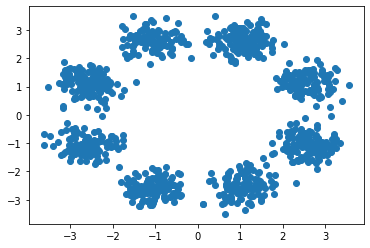

In [118]:
Xnp = X.numpy()
plt.scatter(Xnp[:,0],Xnp[:,1])
plt.show()

In [119]:
def train_8gaussian(model, optimizer, n_epochs=10001, d=2, batch_size=1024, 
                    device=None, plot_val=True, plot_interval=1000,
                    input_grad=False):
    
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    train_loss = []
    
    pbar = trange(n_epochs)

    for i in pbar:   
        x = torch.tensor(create_gaussians(batch_size), dtype=torch.float32).to(device)

        model.train()
        l = model.forward_kl(x)

        l.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss.append(l.item())
        
        if i%100==0:
            pbar.set_postfix_str(f"loss = {train_loss[-1]:.3f}")

        if plot_val and i % plot_interval == 0:
            val_moons(model, i, device, xmin=-4, xmax=4, ymin=-4, ymax=4)
            
    return train_loss

In [120]:
d = 2


q0 = D.MultivariateNormal(torch.zeros(d, device=device), torch.eye(d,device=device))

flows = []
for i in range(5):
#     param_map = MLP([d // 2, 32, 32, d], init_zeros=True)
    param_map = MLP([d // 2, 32, 32, d], init_zeros=True)
    flows.append(AffineCouplingBlock(param_map))
    flows += [Permute(d, mode='swap')]
    flows += [ActNorm(d)]

model = NormalizingFlows(flows, q0).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  5950


  0%|          | 0/10001 [00:00<?, ?it/s]

/tmp/ipykernel_67864/481330241.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(create_gaussians(batch_size), dtype=torch.float32).to(device)


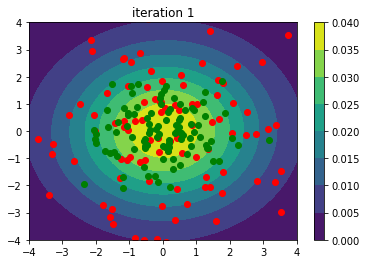

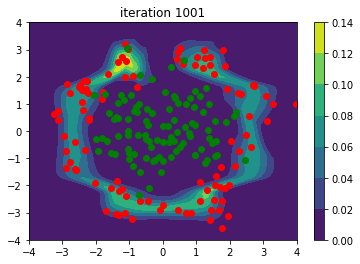

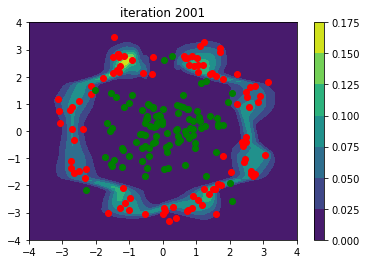

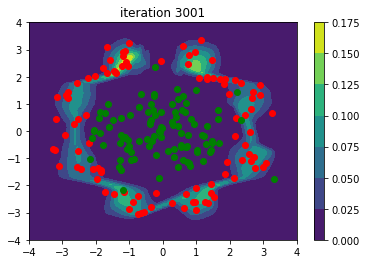

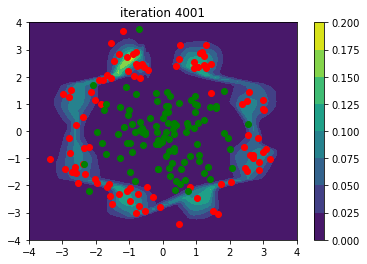

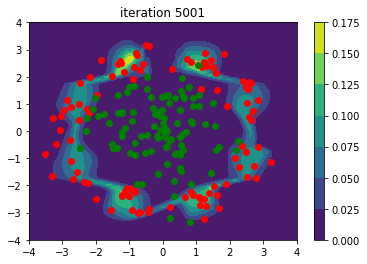

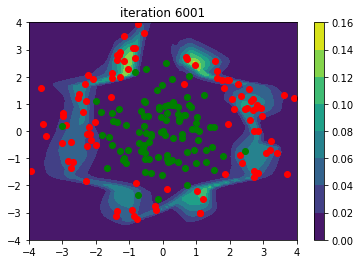

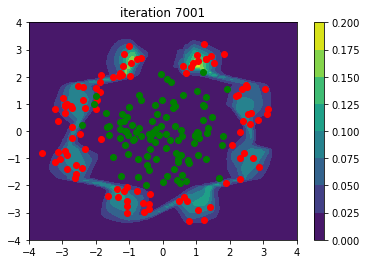

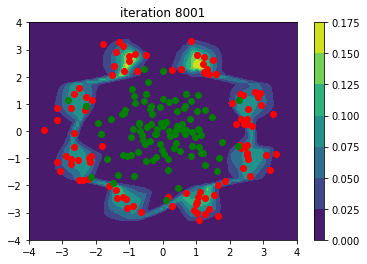

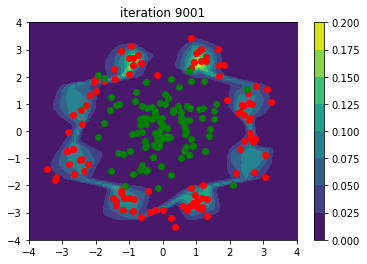

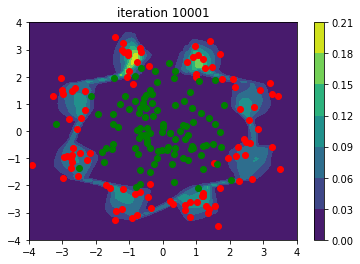

In [121]:
train_loss = train_8gaussian(model,optimizer, batch_size=1024, n_epochs=10001)

### Proposal Resampling

In [20]:
## https://github.com/VincentStimper/resampled-base-flows/blob/master/larsflow/distributions.py

class ResampledGaussian(nn.Module):
    """
    Multivariate Gaussian distribution with diagonal covariance matrix,
    resampled according to a acceptance probability determined by a neural network,
    see arXiv 1810.11428
    """
    def __init__(self, d, a, T, eps, trainable=True):
        """
        Constructor
        :param d: Dimension of Gaussian distribution
        :param a: Function returning the acceptance probability
        :param T: Maximum number of rejections
        :param eps: Discount factor in exponential average of Z
        """
        super().__init__()
        self.d = d
        self.a = a
        self.T = T
        self.eps = eps
        self.register_buffer("Z", torch.tensor(-1.))
        if trainable:
            self.loc = nn.Parameter(torch.zeros(1, self.d))
            self.log_scale = nn.Parameter(torch.zeros(1, self.d))
        else:
            self.register_buffer("loc", torch.zeros(1, self.d))
            self.register_buffer("log_scale", torch.zeros(1, self.d))

    def sample(self, num_samples=(1,)):
        num_samples = num_samples[0]
        t = 0
        eps = torch.zeros(num_samples, self.d, dtype=self.loc.dtype, device=self.loc.device)
        s = 0
        n = 0
        Z_sum = 0
        for i in range(self.T):
            eps_ = torch.randn((num_samples, self.d), dtype=self.loc.dtype, device=self.loc.device)
            acc = self.a(eps_)
            if self.training or self.Z < 0.:
                Z_sum = Z_sum + torch.sum(acc).detach()
                n = n + num_samples
            dec = torch.rand_like(acc) < acc
            for j, dec_ in enumerate(dec[:, 0]):
                if dec_ or t == self.T - 1:
                    eps[s, :] = eps_[j, :]
                    s = s + 1
                    t = 0
                else:
                    t = t + 1
                if s == num_samples:
                    break
            if s == num_samples:
                break
        z = self.loc + torch.exp(self.log_scale) * eps
        log_p_gauss = - 0.5 * self.d * np.log(2 * np.pi) \
                      - torch.sum(self.log_scale, 1)\
                      - torch.sum(0.5 * torch.pow(eps, 2), 1)
        acc = self.a(eps)
        if self.training or self.Z < 0.:
            eps_ = torch.randn((num_samples, self.d), dtype=self.loc.dtype, device=self.loc.device)
            Z_batch = torch.mean(self.a(eps_))
            Z_ = (Z_sum + Z_batch.detach() * num_samples) / (n + num_samples)
            if self.Z < 0.:
                self.Z = Z_
            else:
                self.Z = (1 - self.eps) * self.Z + self.eps * Z_
            Z = Z_batch - Z_batch.detach() + self.Z
        else:
            Z = self.Z
        alpha = (1 - Z) ** (self.T - 1)
        log_p = torch.log((1 - alpha) * acc[:, 0] / Z + alpha) + log_p_gauss

        return z

    def log_prob(self, z):
        eps = (z - self.loc) / torch.exp(self.log_scale)
        log_p_gauss = - 0.5 * self.d * np.log(2 * np.pi) \
                      - torch.sum(self.log_scale, 1) \
                      - torch.sum(0.5 * torch.pow(eps, 2), 1)
        acc = self.a(eps)
        if self.training or self.Z < 0.:
            eps_ = torch.randn_like(z)
            Z_batch = torch.mean(self.a(eps_))
            if self.Z < 0.:
                self.Z = Z_batch.detach()
            else:
                self.Z = (1 - self.eps) * self.Z + self.eps * Z_batch.detach()
            Z = Z_batch - Z_batch.detach() + self.Z
        else:
            Z = self.Z
        alpha = (1 - Z) ** (self.T - 1)
        log_p = torch.log((1 - alpha) * acc[:, 0] / Z + alpha) + log_p_gauss
        return log_p

    def estimate_Z(self, num_samples, num_batches=1):
        """
        Estimate Z via Monte Carlo sampling
        :param num_samples: Number of samples to draw per batch
        :param num_batches: Number of batches to draw
        """
        with torch.no_grad():
            self.Z = self.Z * 0.
            # Get dtype and device
            dtype = self.Z.dtype
            device = self.Z.device
            for i in range(num_batches):
                eps = torch.randn((num_samples, self.d), dtype=dtype,
                                  device=device)
                acc_ = self.a(eps)
                Z_batch = torch.mean(acc_)
                self.Z = self.Z + Z_batch.detach() / num_batches

In [158]:
a = MLP([d, 256, 256, 1], output_fn="sigmoid")
q0 = ResampledGaussian(d, a, 100, 0.1, trainable=False)

In [159]:
flows = []
for i in range(5):
#     param_map = MLP([d // 2, 32, 32, d], init_zeros=True)
    param_map = MLP([d // 2, 32, 32, d], init_zeros=True)
    flows.append(AffineCouplingBlock(param_map))
    flows += [Permute(d, mode='swap')]
    flows += [ActNorm(d)]

model = NormalizingFlows(flows, q0).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  72767


  0%|          | 0/10001 [00:00<?, ?it/s]

/tmp/ipykernel_67864/481330241.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(create_gaussians(batch_size), dtype=torch.float32).to(device)


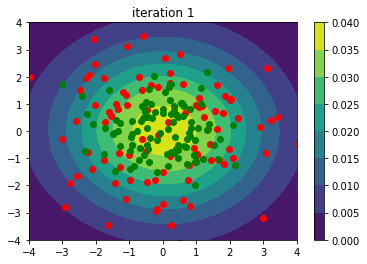

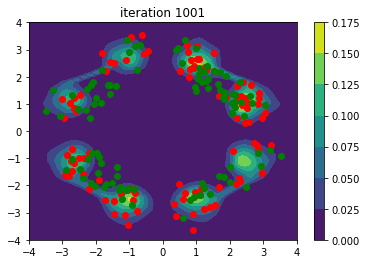

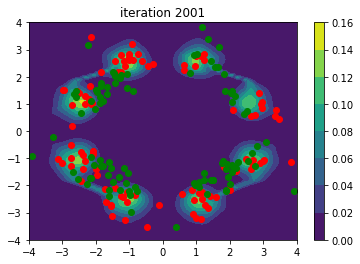

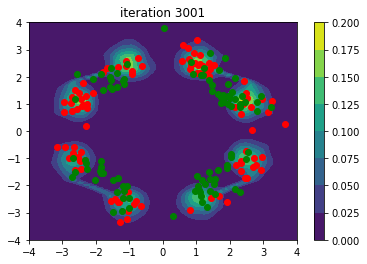

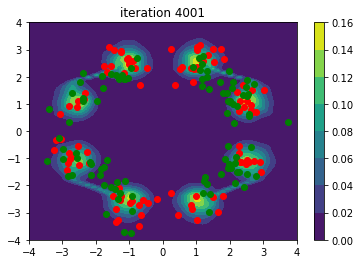

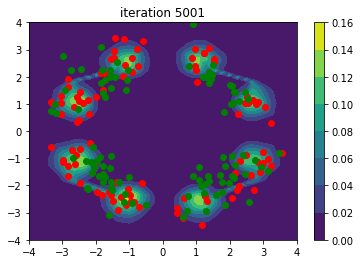

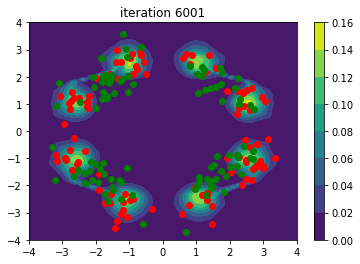

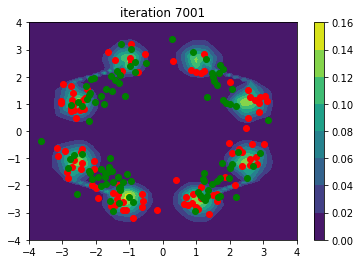

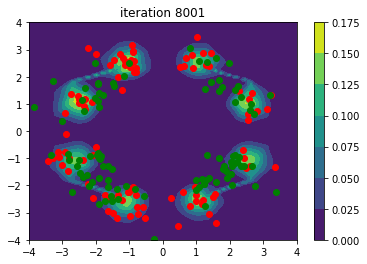

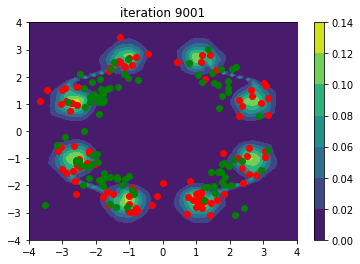

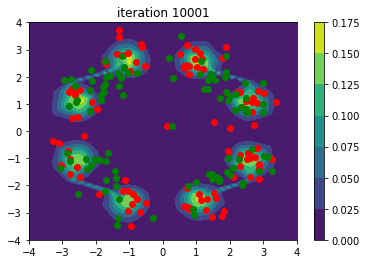

In [160]:
train_loss = train_8gaussian(model,optimizer, batch_size=1024, n_epochs=10001)

In [163]:
a = MLP([d, 256, 256, 1], output_fn="sigmoid")
q0 = ResampledGaussian(d, a, 100, 0.1, trainable=False)

flows = []
for i in range(5):
#     param_map = MLP([d // 2, 32, 32, d], init_zeros=True)
    param_map = MLP([d // 2, 32, 32, d], init_zeros=True)
    flows.append(AffineCouplingBlock(param_map))
    flows += [Permute(d, mode='swap')]
    flows += [ActNorm(d)]

model = NormalizingFlows(flows, q0).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  72767


  0%|          | 0/20001 [00:00<?, ?it/s]

/tmp/ipykernel_67864/481330241.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(create_gaussians(batch_size), dtype=torch.float32).to(device)


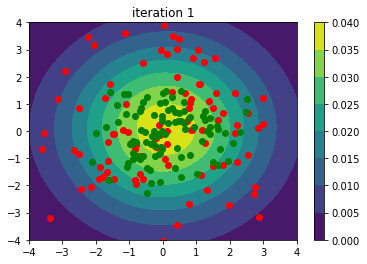

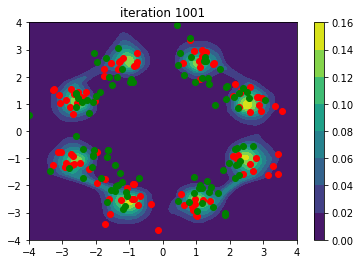

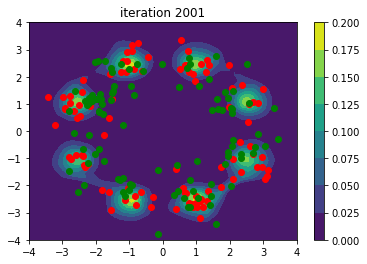

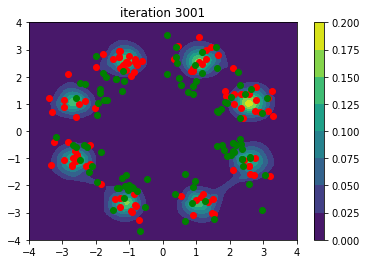

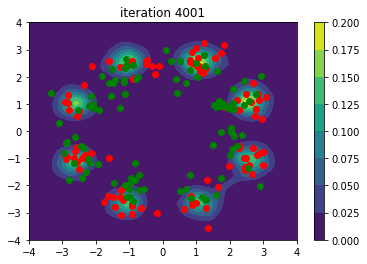

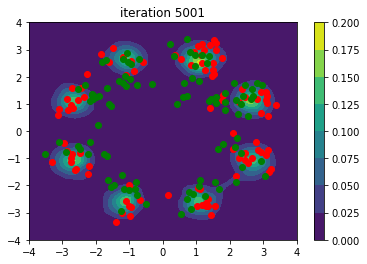

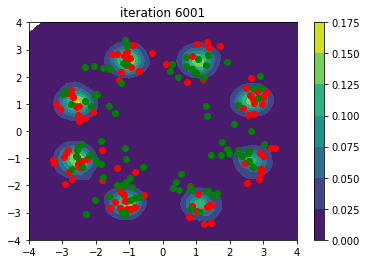

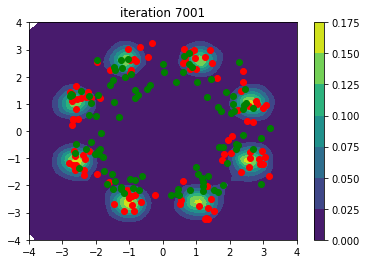

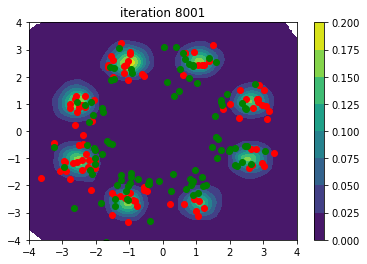

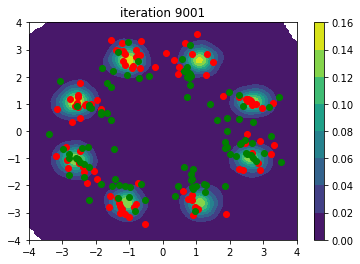

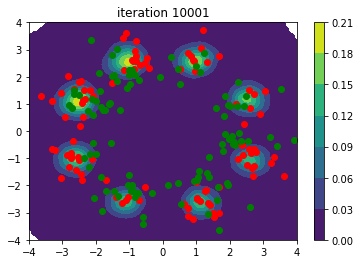

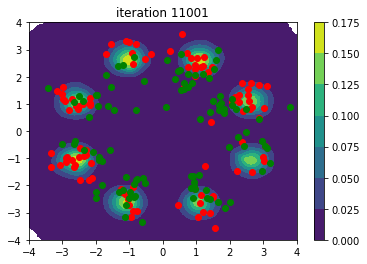

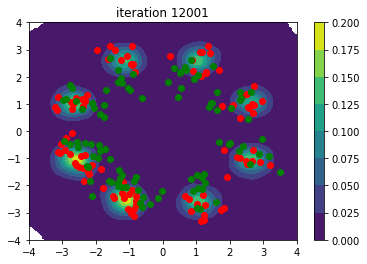

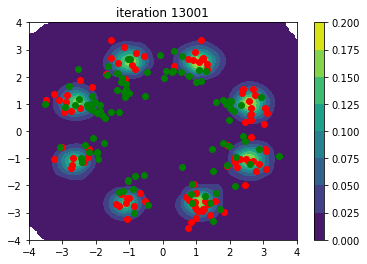

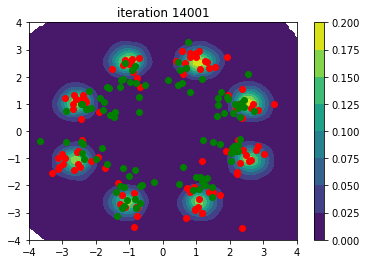

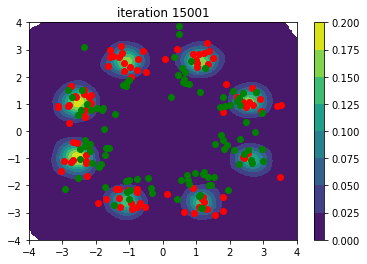

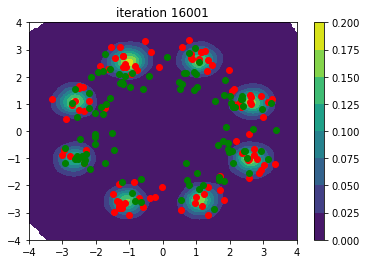

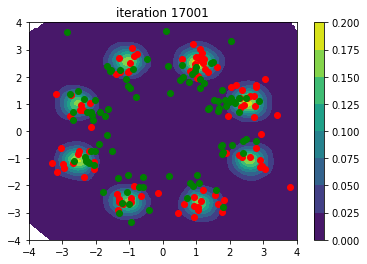

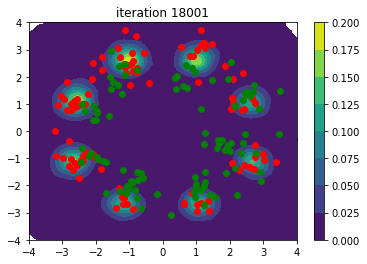

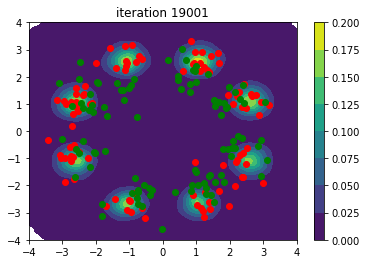

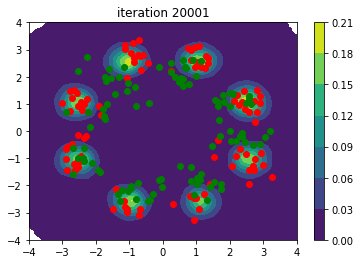

In [164]:
train_loss = train_8gaussian(model,optimizer, batch_size=1024, n_epochs=20001)

### Real NVP

**Affine coupling layer:** Let $d=\frac{D}{2}$ (we could use an other d),
\begin{equation*}
    \begin{cases}
        z_{1:d} = x_{1:d} \\
        z_{d+1:D} = \exp(s(x_{1:d}))\odot x_{d+1:D}+m(x_{1:d})
    \end{cases}
\end{equation*}

with $m$ a neural network.

For inverting, we got:
\begin{equation*}
    \begin{cases}
        x_{1:d} = z_{1:d} \\
        x_{d+1:D} = \exp(-s(z_{1:d}))\odot (z_{d+1:D}-m(z_{1:d}))
    \end{cases}
\end{equation*}

And $\det J_T(x) = \exp{\sum_j s(x_{1:d})_j}$.

**Batch Norm Layer**: Let $m$ be the mean and $v$ be the variance (of a batch in training time, and of the whole training set in testing time), then a batch norm is:
\begin{equation*}
    x = (z-\beta)\odot e^{-\gamma}\odot (v+\epsilon)^{\frac12}+m
\end{equation*}
with $\gamma$ and $\beta$ some learnable parameters and $\epsilon$ a constant ensuring numerical stability. The invert is:
\begin{equation*}
    z = (x-m)\odot (v+\epsilon)^{-\frac12}\odot e^\gamma +\beta
\end{equation*}
Note that we could put $\gamma$ instead of $e^\gamma$. Then, we have: $\det J_T(x) = e^{\sum_j \gamma_j-\frac12\log(v_j+\epsilon)}$.

A Real NVP is composed of affine coupling layers and batch norm layers. To permute indices, we can just permute even and odd indices (or first and last part of vectors) as it is done here. We could also add permutation or reverse layers.

Possible improvement: Masked convolution: Partitioning is done by using a binary mask $b$:
\begin{equation*}
    y = b\odot x+(1-b)\odot(x\odot\exp(s(b\odot x))+t(b\odot x))
\end{equation*}

### References

<a id="reference1"></a>

[1] Dinh, L., Sohl-Dickstein, J., & Bengio, S. Density estimation using Real NVP. arXiv preprint arXiv:1605.08803. (2016). [link](https://arxiv.org/abs/1605.08803)